<a href="https://colab.research.google.com/github/Airdef/CV/blob/main/assignment_module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [125]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [126]:
label_map={
0:  "Apple",
1:  "Avocado",
2:  "Banana",
3:  "Kiwi",
4:  "Lemon",
5:  "Lime",
6:  "Mango",
7:  "Melon",
8:  "Nectarine",
9:  "Orange",
10: "Papaya",
11: "Passion-Fruit",
12: "Peach",
13: "Pear",
14: "Pineapple",
15: "Plum",
16: "Pomegranate",
17: "Red-Grapefruit",
18: "Satsumas",
19: "Juice",
20: "Milk",
21: "Oatghurt",
22: "Oat-Milk",
23: "Sour-Cream",
24: "Sour-Milk",
25: "Soyghurt",
26: "Soy-Milk",
27: "Yoghurt",
28: "Asparagus",
29: "Aubergine",
30: "Cabbage",
31: "Carrots",
32: "Cucumber",
33: "Garlic",
34: "Ginger",
35: "Leek",
36: "Mushroom",
37: "Onion",
38: "Pepper",
39: "Potato",
40: "Red-Beet",
41: "Tomato",
42: "Zucchini"
}


n_classes=len(label_map)
print(n_classes)

43


In [127]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [128]:
from torch.utils.data import DataLoader
from torchvision import transforms as T, datasets
from torch import nn
import numpy as np
import random
import torch
from matplotlib import pyplot as plt
from torch.optim import Adam
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [129]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

PART 1

In [130]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [131]:
im_dim=256
tsfms = T.Compose([
    T.Resize((im_dim, im_dim)),
    T.ToTensor(),
    T.Lambda(lambda x: x.flatten())
])

# Initialize datasets
train_dataset = GroceryStoreDataset(split='train',transform=tsfms  )
val_dataset = GroceryStoreDataset(split='val',transform=tsfms )
test_dataset = GroceryStoreDataset(split='test', transform=tsfms)

input_dim = len(train_dataset[0][0])
print(input_dim)

196608


In [132]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, val_dl=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    for e in tqdm(range(epochs)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use

        train_acc /= train_samples
        train_loss /= train_samples

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose :
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch

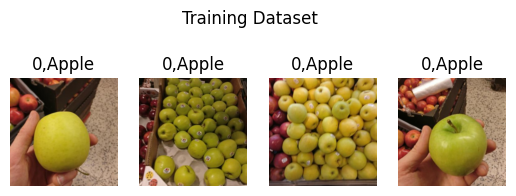

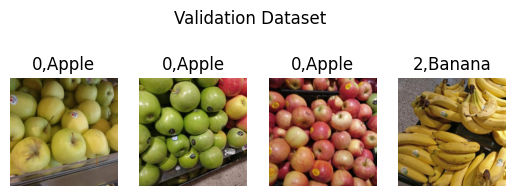

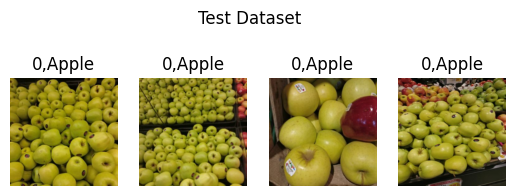

In [133]:

fig, ax = plt.subplots(1, 4)
fig.suptitle('Training Dataset',y=0.75)  # Title for the first row
for i, idx in enumerate([0, 10, 20, 30]):
    img, label =train_dataset[idx]
    ax[i].imshow(img.reshape(3, im_dim, im_dim).permute(1, 2, 0))
    ax[i].set_title(f"{label},{label_map[label]}")
    ax[i].axis("off")

fig, ax = plt.subplots(1, 4)
fig.suptitle('Validation Dataset',y=0.75)  # Title for the first row
for i, idx in enumerate([0, 10, 20, 30]):
    img, label = val_dataset[idx]
    ax[i].imshow(img.reshape(3, im_dim, im_dim).permute(1, 2, 0))
    ax[i].set_title(f"{label},{label_map[label]}")
    ax[i].axis("off")

fig, ax = plt.subplots(1, 4)
fig.suptitle('Test Dataset',y=0.75)  # Title for the first row
for i, idx in enumerate([0, 10, 20, 30]):
    img, label = test_dataset[idx]
    ax[i].imshow(img.reshape(3, im_dim, im_dim).permute(1, 2, 0))
    ax[i].set_title(f"{label},{label_map[label]}")
    ax[i].axis("off")



Prepare Data

In [134]:
batch_size = 512
train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)


Classifier

In [142]:
def hidden_code(input_dim, out_dim):
    modules = []
    modules.append(nn.Linear(input_dim, out_dim))
    modules.append(nn.BatchNorm1d(out_dim))
    modules.append(nn.ReLU())

    return nn.Sequential(*modules)

In [143]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        # Initialize the modules we need to build the network
        self.fcF = nn.Linear(input_dim, hidden_dim)
        self.Norm=nn.BatchNorm1d(hidden_dim)
        self.act = nn.ReLU()
        self.fcH = nn.Linear(hidden_dim, hidden_dim)
        self.last = nn.Linear(hidden_dim, n_classes)

        self.hidden_layers = nn.ModuleList([
            hidden_code(hidden_dim, hidden_dim) for i in range(n_hidden_layers)
        ])

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        out = self.fcF(x)
        out=self.Norm(out)
        out = self.act(out)
        for layer in self.hidden_layers:
          out = layer(out)
        out = self.last(out)

        return out

In [144]:
hidden_dim = 128

model = Classifier(
    input_dim,
    hidden_dim,
    n_classes,
    n_hidden_layers=3
)
for name, params in model.named_parameters():
    print(f"{name}: {params.shape}")


fcF.weight: torch.Size([128, 196608])
fcF.bias: torch.Size([128])
Norm.weight: torch.Size([128])
Norm.bias: torch.Size([128])
fcH.weight: torch.Size([128, 128])
fcH.bias: torch.Size([128])
last.weight: torch.Size([43, 128])
last.bias: torch.Size([43])
hidden_layers.0.0.weight: torch.Size([128, 128])
hidden_layers.0.0.bias: torch.Size([128])
hidden_layers.0.1.weight: torch.Size([128])
hidden_layers.0.1.bias: torch.Size([128])
hidden_layers.1.0.weight: torch.Size([128, 128])
hidden_layers.1.0.bias: torch.Size([128])
hidden_layers.1.1.weight: torch.Size([128])
hidden_layers.1.1.bias: torch.Size([128])
hidden_layers.2.0.weight: torch.Size([128, 128])
hidden_layers.2.0.bias: torch.Size([128])
hidden_layers.2.1.weight: torch.Size([128])
hidden_layers.2.1.bias: torch.Size([128])


In [145]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")
model.to(device)

Device: cuda


Classifier(
  (fcF): Linear(in_features=196608, out_features=128, bias=True)
  (Norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (fcH): Linear(in_features=128, out_features=128, bias=True)
  (last): Linear(in_features=128, out_features=43, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
)

In [146]:
optimizer = Adam(model.parameters(), lr=0.001)

In [147]:
epochs = 20

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    epochs,
    optimizer,
    val_dl,
    verbose=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: train loss 3.541 - train acc 0.125 - valid loss 3.609 - valid acc 0.007
Epoch 1: train loss 2.963 - train acc 0.330 - valid loss 3.562 - valid acc 0.030
Epoch 2: train loss 2.638 - train acc 0.356 - valid loss 3.430 - valid acc 0.101
Epoch 3: train loss 2.395 - train acc 0.393 - valid loss 3.242 - valid acc 0.162
Epoch 4: train loss 2.193 - train acc 0.425 - valid loss 3.067 - valid acc 0.172
Epoch 5: train loss 2.013 - train acc 0.475 - valid loss 2.989 - valid acc 0.193
Epoch 6: train loss 1.843 - train acc 0.510 - valid loss 2.885 - valid acc 0.206
Epoch 7: train loss 1.684 - train acc 0.552 - valid loss 2.891 - valid acc 0.199
Epoch 8: train loss 1.527 - train acc 0.598 - valid loss 2.860 - valid acc 0.226
Epoch 9: train loss 1.380 - train acc 0.661 - valid loss 2.879 - valid acc 0.206
Epoch 10: train loss 1.243 - train acc 0.705 - valid loss 2.885 - valid acc 0.199
Epoch 11: train loss 1.104 - train acc 0.765 - valid loss 2.887 - valid acc 0.209
Epoch 12: train loss 0.973